## Example: Image Segmentation with FCN

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

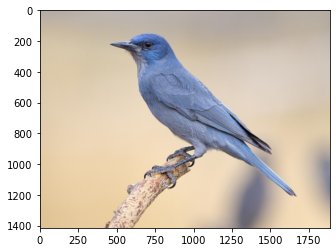

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

img = Image.open('pinyon-jay-bird.jpg')
plt.imshow(img); plt.show()

In [ ]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [ ]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

In [ ]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

## Assignment: Dogs and Cats Classification with AlexNet

In [1]:
import torch
torch.cuda.empty_cache()

In [1]:
# Set the seed value

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import torchvision.transforms as T

from PIL import Image
from torch import nn

seed = torch.initial_seed()

train_batch_size = 50  # Define train batch size
test_batch_size = 500  # Define test batch size (can be larger than train batch size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



# define class to build dataset
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,image_list):
        self.image_list= image_list       # list of image names
        self.file_path='./train'
    def __getitem__(self, idx):

        image_name = self.image_list[idx]

        data, label = Image.open(self.file_path+'/'+image_name), image_name[:3]     #  the first three characters for label
        label = (1 if label == 'cat' else 0)       # label 1 if is cat, else 0 if dog

        transform = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
        return transform(data).to(device), torch.tensor(label).to(device)
    
    def __len__(self):
        return len(self.image_list)

file_path='./train'
image_list= os.listdir(file_path)
random.shuffle(image_list)

n, ratio = len(image_list), 0.8

train_image_list = image_list[:int(ratio*n)]
test_image_list = image_list[int(ratio*n):]

train_dataset=BuildDataset(train_image_list)
test_dataset=BuildDataset(test_image_list)


cuda:0


In [2]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

validation_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
)

len_train=len(train_image_list)
len_val=len(test_image_list)
print(len_train)
print(len_val)

20000
5000


In [3]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=36, kernel_size=12, stride=4, padding=0, bias=False),
            nn.BatchNorm2d(36),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=36, out_channels=56, kernel_size=5, stride=1, padding=2,bias=False),
            nn.BatchNorm2d(56),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=56, out_channels=78, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=78, out_channels=78, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=78, out_channels=56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6*6*56, 3*6*20),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*20, 3*4*5),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*5,num_classes),
        )
        self.classifier=nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv(x)
        
        # reduce the dimensions for linear layer input
        out = out.view(out.size(0), 6*6*56)       
        
        out = self.fc(out)
        
        prob = self.classifier(out)
        return prob

In [4]:
import numpy as np
import tqdm

# initialize the number of classes for output
model = AlexNet(2)
model.to(device)

# define Adam optimizer with learning rate 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

epochs = 10

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# every 25 iterations for log
log_interval = 25

loss_list = []
iteration_list = []
accuracy_list = []
count = 0

if __name__ =='__main__':
    for epoch in tqdm.trange(epochs):
        for idx, (data, labels) in enumerate(train_loader):
    
            # Calculate training loss on model
            pred_y = model(data)
            loss = loss_fn(pred_y, labels)
            # zeros gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # save loss and accuracy for every 25 iterations
            if idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        idx * train_batch_size,
                        len_train,
                        100.0 * idx *train_batch_size/ len_train,
                        loss.item(),
                    )
                )
                loss_list.append(loss.item())
                count += log_interval
                iteration_list.append(count)
                
                # calculate validation accuracy
                with torch.no_grad():
                    n_sample = len_val
                    n_correct = 0
                    for idxx, (data, labels) in enumerate(validation_loader):
                        #data=data.to(device)
                        #labels=labels.to(device)
                        pred_y = model(data).to('cpu')
                        labels=labels.to('cpu')
                        n_correct += sum(
                            (torch.argmax(pred_y, dim=1) == labels).type(torch.FloatTensor)
                        )
                    accuracy_list.append(100.0 * n_correct / n_sample)
                    print(
                        "Validation set: number of correct labels: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct), n_sample, 100.0 * n_correct / n_sample
                        )
                    )

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.692629
Validation set: number of correct labels: 2525/5000 accuracy: (50%)

Train Epoch: 1 [5000/20000 (25%)]	Loss: 0.612194
Validation set: number of correct labels: 3339/5000 accuracy: (67%)

Train Epoch: 1 [10000/20000 (50%)]	Loss: 0.593408
Validation set: number of correct labels: 3482/5000 accuracy: (70%)

Train Epoch: 1 [15000/20000 (75%)]	Loss: 0.588625
Validation set: number of correct labels: 3413/5000 accuracy: (68%)



 10%|████████                                                                        | 1/10 [40:15<6:02:17, 2415.28s/it]

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.635720
Validation set: number of correct labels: 3458/5000 accuracy: (69%)

Train Epoch: 2 [5000/20000 (25%)]	Loss: 0.577538
Validation set: number of correct labels: 3641/5000 accuracy: (73%)

Train Epoch: 2 [10000/20000 (50%)]	Loss: 0.524689
Validation set: number of correct labels: 3664/5000 accuracy: (73%)

Train Epoch: 2 [15000/20000 (75%)]	Loss: 0.485612
Validation set: number of correct labels: 3739/5000 accuracy: (75%)



 20%|███████████████▌                                                              | 2/10 [1:22:36<5:31:52, 2489.12s/it]

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.487767
Validation set: number of correct labels: 3807/5000 accuracy: (76%)

Train Epoch: 3 [5000/20000 (25%)]	Loss: 0.597372
Validation set: number of correct labels: 3803/5000 accuracy: (76%)

Train Epoch: 3 [10000/20000 (50%)]	Loss: 0.525197
Validation set: number of correct labels: 3830/5000 accuracy: (77%)

Train Epoch: 3 [15000/20000 (75%)]	Loss: 0.550939
Validation set: number of correct labels: 3864/5000 accuracy: (77%)



 30%|███████████████████████▍                                                      | 3/10 [1:38:03<3:27:12, 1776.01s/it]

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.389214
Validation set: number of correct labels: 3939/5000 accuracy: (79%)

Train Epoch: 4 [5000/20000 (25%)]	Loss: 0.456300
Validation set: number of correct labels: 3877/5000 accuracy: (78%)

Train Epoch: 4 [10000/20000 (50%)]	Loss: 0.553530
Validation set: number of correct labels: 3940/5000 accuracy: (79%)

Train Epoch: 4 [15000/20000 (75%)]	Loss: 0.446342
Validation set: number of correct labels: 3949/5000 accuracy: (79%)



 40%|███████████████████████████████▏                                              | 4/10 [1:44:25<2:02:34, 1225.81s/it]

Train Epoch: 5 [0/20000 (0%)]	Loss: 0.466539
Validation set: number of correct labels: 3935/5000 accuracy: (79%)

Train Epoch: 5 [5000/20000 (25%)]	Loss: 0.432276
Validation set: number of correct labels: 4012/5000 accuracy: (80%)

Train Epoch: 5 [10000/20000 (50%)]	Loss: 0.496195
Validation set: number of correct labels: 4006/5000 accuracy: (80%)

Train Epoch: 5 [15000/20000 (75%)]	Loss: 0.522090
Validation set: number of correct labels: 4057/5000 accuracy: (81%)



 50%|███████████████████████████████████████▌                                       | 5/10 [1:50:52<1:16:55, 923.11s/it]

Train Epoch: 6 [0/20000 (0%)]	Loss: 0.445417
Validation set: number of correct labels: 3980/5000 accuracy: (80%)

Train Epoch: 6 [5000/20000 (25%)]	Loss: 0.562842
Validation set: number of correct labels: 4104/5000 accuracy: (82%)

Train Epoch: 6 [10000/20000 (50%)]	Loss: 0.538992
Validation set: number of correct labels: 4018/5000 accuracy: (80%)

Train Epoch: 6 [15000/20000 (75%)]	Loss: 0.538047
Validation set: number of correct labels: 4094/5000 accuracy: (82%)



 60%|██████████████████████████████████████████████▏                              | 6/10 [9:20:50<10:52:35, 9788.75s/it]

Train Epoch: 7 [0/20000 (0%)]	Loss: 0.418467
Validation set: number of correct labels: 4129/5000 accuracy: (83%)

Train Epoch: 7 [5000/20000 (25%)]	Loss: 0.507152
Validation set: number of correct labels: 4157/5000 accuracy: (83%)

Train Epoch: 7 [10000/20000 (50%)]	Loss: 0.405996
Validation set: number of correct labels: 4182/5000 accuracy: (84%)

Train Epoch: 7 [15000/20000 (75%)]	Loss: 0.464190
Validation set: number of correct labels: 4225/5000 accuracy: (84%)



 70%|██████████████████████████████████████████████████████▌                       | 7/10 [9:27:48<5:36:15, 6725.16s/it]

Train Epoch: 8 [0/20000 (0%)]	Loss: 0.465650
Validation set: number of correct labels: 4009/5000 accuracy: (80%)

Train Epoch: 8 [5000/20000 (25%)]	Loss: 0.368466
Validation set: number of correct labels: 4148/5000 accuracy: (83%)

Train Epoch: 8 [10000/20000 (50%)]	Loss: 0.497830
Validation set: number of correct labels: 4162/5000 accuracy: (83%)

Train Epoch: 8 [15000/20000 (75%)]	Loss: 0.470351
Validation set: number of correct labels: 4178/5000 accuracy: (84%)



 80%|██████████████████████████████████████████████████████████████▍               | 8/10 [9:35:34<2:37:45, 4732.61s/it]

Train Epoch: 9 [0/20000 (0%)]	Loss: 0.461216
Validation set: number of correct labels: 4163/5000 accuracy: (83%)

Train Epoch: 9 [5000/20000 (25%)]	Loss: 0.423186
Validation set: number of correct labels: 4236/5000 accuracy: (85%)

Train Epoch: 9 [10000/20000 (50%)]	Loss: 0.528916
Validation set: number of correct labels: 4184/5000 accuracy: (84%)

Train Epoch: 9 [15000/20000 (75%)]	Loss: 0.480238
Validation set: number of correct labels: 4136/5000 accuracy: (83%)



 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [9:42:13<56:17, 3377.87s/it]

Train Epoch: 10 [0/20000 (0%)]	Loss: 0.455111
Validation set: number of correct labels: 4129/5000 accuracy: (83%)

Train Epoch: 10 [5000/20000 (25%)]	Loss: 0.487369
Validation set: number of correct labels: 4291/5000 accuracy: (86%)

Train Epoch: 10 [10000/20000 (50%)]	Loss: 0.425948
Validation set: number of correct labels: 4226/5000 accuracy: (85%)

Train Epoch: 10 [15000/20000 (75%)]	Loss: 0.407642
Validation set: number of correct labels: 4277/5000 accuracy: (86%)



100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [9:49:31<00:00, 3537.14s/it]


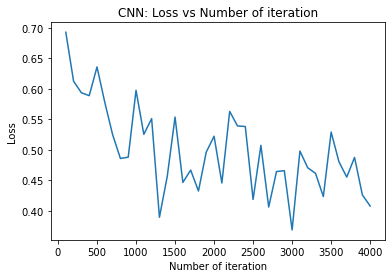

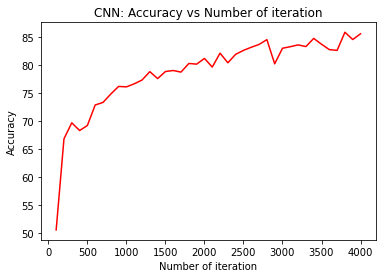

In [5]:
import matplotlib.pyplot as plt

# visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

# Prediction on first 10 test images

In [35]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
              T.CenterCrop(224),
              T.ToTensor(), 
              T.Normalize(mean = [0.485, 0.456, 0.406], 
              std = [0.229, 0.224, 0.225])])
  

file_path ='./test'



def get_prediction(file_path, num):
    
    imgs = os.listdir(file_path)
    imgs.sort()
    imgs=imgs[:num]
    imgs=[ Image.open(file_path+'/'+i) for i in imgs]


    inp = list(map(lambda x: trf(x) , imgs))
    inp = torch.stack(inp,dim=0)
    inp=inp.to(device)

    pred= model(inp)
    pred=pred.to('cpu')

    return [{'dog':i[0].item(), 'cat':i[1].item()} for i in pred],imgs




pred,imgs=get_prediction(file_path,10)

fig,ax = plt.subplots(2,5,figsize=(15,10))
count=0
for idx,image in enumerate(imgs):
    img=imgs[idx]
    ax[idx//5][idx%5].axis('off')
    ax[idx//5][idx%5].imshow(img)
    if pred[idx]['cat']<pred[idx]['dog']:count+=1
    ax[idx//5][idx%5].set_title('cat: {:.1f}%, dog :{:.1f}%'.format(100.0*pred[idx]['cat'], 100.0*pred[idx]['dog']))

# Visualization on feature map

In [104]:
model.to('cpu')

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

sequential_1 = list(model.children())[0]

for child in sequential_1:
    if type(child) == nn.Conv2d:
        counter+=1
        model_weights.append(child.weight)
        conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


file_path='./test'

def visua_random(file_path):
    img=random.choice(os.listdir(file_path))
    img=Image.open(file_path+'/'+img)
    plt.imshow(img)
    img=trf(img).unsqueeze(0)
    outputs = []    
    names=[]
    for layer in conv_layers:
        img = layer(img)
        outputs.append(img)
        names.append(str(layer))
    #print feature_maps
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    
    return 

visua_random(file_path)

Total convolution layers: 5
conv_layers


The learning rate used is 0.0002 with Adam Optimizer,

batch size used is 50,

dropout layers are used after the first 2 FC layers,

batch normalization is used after the first 2 convolution layers.

The best accuracy achieved is 86%
